In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# For reproducible random results.
np.random.seed(789)

# The following utility functions are provided for your convenience.
# You may use them in your solution, or you may write your own.
# Do not alter them, and please read the docstrings carefully.
K = np.array([[471.14628085,  -4.94771211, 295.13159043], [0., 436.71106326, 240.96582594], [0., 0., 1.]])
SQUARE_SIZE = 0.0205

## Problem 1.1

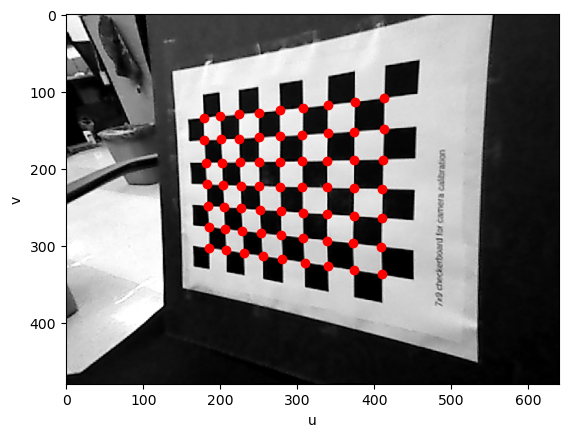

In [3]:
# Read the image from file
img_path = "p1_data/checkerboard.png"
image = cv2.imread(img_path, 0)

# Plot Corners on top of image
fig = plt.figure()
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_ylabel("v")
ax.set_xlabel("u")

# 1) Find the corner locations of the chessboard in image space.
#    Hint: Use the function cv2.findChessboardCorners(image, (num_corners_x, num_corners_y))
#    Hint: findChessboardCorners outputs pixel coordinates!
# 2) Plot their location in image space over top of the image.
#    Hint: use ax.plot(...) -- should be one line!
#    Hint: This should only be 1 line of code!

ncorners_y = 7
ncorners_x = 9
# --------- YOUR CODE STARTS HERE ---------------

retval, corners = cv2.findChessboardCorners(image, (ncorners_x,ncorners_y), None)
ax.plot(corners[:,:,0], corners[:,:,1], 'ro')

# --------- YOUR CODE ENDS HERE -----------------

## Problem 1.2

In [4]:
# 1)  Compute the homography, H.
#     1.a) Use the SQUARE_SIZE, and the dimensions of the grid above to
#             to create a the array P = [[X_0, Y_0, 1], .... [X_n, Y_n, 1]].
#             P should have shape (63, 3).
#          Hint: Use np.meshgrid to generate the X, Y coordinates, and
#             array.reshape and np.hstack to form the final matrix.
#     1.b) Form the M matrix outlined in the write-up!
#     1.c) Use np.linalg.svd(M) to solve for the nullspace of M and recover H.
#          Hint: np.linalg.svd(M) returns V.T.
#          Hint: Use <array>.reshape(3, 3) to give H the proper dimensions.
# 2)  Compute the camera pose rotation, R, and translation, t.
#     2.a) Compute KinvH = inv(K) @ H.
#          Hint: Use np.linalg.inv().
#     2.b) Normalize the values of KinvH to it's first column.
#          Hint: Use np.linalg.norm() and the / operator.
#     2.c) Compute r0, r1, r2, and t as outlined in the write-up.
#          Hint: Use np.cross().
#     2.d) Form R from r0, r1, and r2.
#          Hint: Use np.column_stack()

# --------- YOUR CODE STARTS HERE ---------------

x = np.linspace(0, (ncorners_x-1)*SQUARE_SIZE, ncorners_x)
y = np.linspace(0, (ncorners_y-1)*SQUARE_SIZE, ncorners_y)

# Create a grid of (x, y) coordinate pairs using np.meshgrid
X, Y = np.meshgrid(x, y)
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
P = np.hstack((X,Y, np.ones((X.shape[0],1))))
print(P.shape)

M = np.zeros((2*P.shape[0], 3*P.shape[1]))
print("M shape", M.shape)

for i in range(P.shape[0]):
    M[2*i,:3] = np.array([-P[i,0], -P[i,1], -1])
    M[2*i,-3:] = np.array([P[i,0]*corners[i,0,0], P[i,1]*corners[i,0,0], corners[i,0,0]])

    M[2*i+1, 3:6] = np.array([-P[i,0], -P[i,1], -1])
    M[2*i+1, -3:] = np.array([P[i,0]*corners[i,0,1], P[i,1]*corners[i,0,1], corners[i,0,1]])

u, s, v = np.linalg.svd(M)
# print(u.shape, s.shape, vh.shape)
v = v.T
H = v[:,np.argmin(s)].reshape(3,3)

C = np.matmul(np.linalg.inv(K),H)
lam = np.linalg.norm(C[:,0],2)
C = C/lam
r0 = (C[:,0].copy())
r1 = (C[:,1].copy())
t = C[:,2].copy()

# t = np.array([-0.07817338, -0.07689063, -0.23994245])
r2 = (np.cross(r0,r1))
R = np.vstack((r0, r1, r2))
R = R.T
print(R,t)

# --------- YOUR CODE ENDS HERE -----------------

(63, 3)
M shape (126, 9)
[[ 0.84159518  0.02457411  0.55448957]
 [ 0.04607233  1.01948989 -0.12028731]
 [-0.53814022  0.12721435  0.85686559]] [-0.06041666 -0.05504642 -0.24836523]


## Problem 1.3

(63, 3)


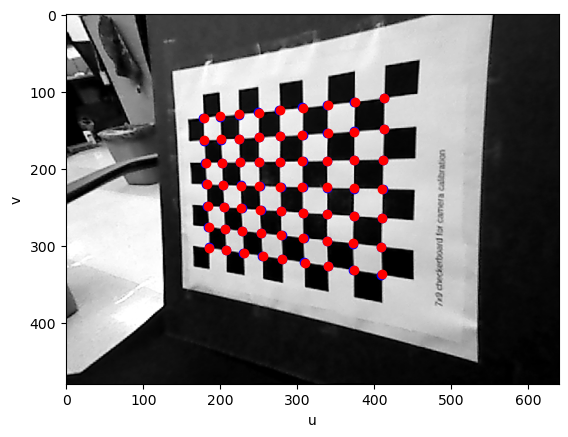

In [10]:
# 1) Finish the transform_world_to_camera function which uses
#       the given K, and the R and t that you calculated!.
#    Hint: You'll need to use some equations from the write-up.

def transform_world_to_camera(K, R, t, world_coords):
    """
    Args:
        K: np.array with shape (3, 3), camera intrinsics matrix.
        R: np.array with shape (3, 3), camera rotation.
        t: np.array with shape (3, ) or (3, 1), camera translation.
        world_coords: np.array with shape (N, 3), cartesian coordinates (X, Y, Z)
            in world frame to transform into camera pixel space.
    Return:
        uv: np.array with shape (N, 2), with (u, v) coordinates of that are
            the projections of the the world_coords on the image plane.
    """
    # --------- YOUR CODE STARTS HERE ---------------

    # N,_ = world_coords.shape

    if world_coords[:,-1].all()==1:
        uv = H@world_coords.T
        uv = uv.T

    elif world_coords[:,-1].all()==0:
        N = world_coords.shape[0]
        world_coords = np.hstack((world_coords, np.ones((N,1))))
        Rt = np.hstack((R, t.reshape(-1,1)))
        print(world_coords[:5,:])

        uv = np.matmul(K, np.matmul(Rt, world_coords.T))
        uv = uv.T



    # --------- YOUR CODE ENDS HERE -----------------
    return uv

ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# 2) Project the global coordinates of the corners that you calculated
#       earlier back onto the image using transform_world_to_camera.
#    Hint: The input world_coords should have shape (63, 3)
#    Hint: Use the Xs and Ys you got earlier and set Zs = 0.
#    Hint: You may need to change some of the variable names at the bottom
#       of this cell to match the names that you used above!

# --------- YOUR CODE STARTS HERE ---------------


print(P.shape)
uv = transform_world_to_camera(K, R, t, P)
u = uv[:,0]/uv[:,2]
v = uv[:,1]/uv[:,2]
#print(uv)
#print(v)
ax.plot(u, v, 'bo')
ax.plot(corners[:,:,0], corners[:,:,1], 'ro')

# --------- YOUR CODE ENDS HERE -----------------

## Project Anything!
Try using your the camera pose you computed to project our secret point cloud (defined in world coordinates) onto the camera frame!

(1000, 3)
[[0.19473099 0.0400013  0.         1.        ]
 [0.19372599 0.04224402 0.         1.        ]
 [0.19539956 0.02126378 0.         1.        ]
 [0.19358379 0.03696876 0.         1.        ]
 [0.19599058 0.01725642 0.         1.        ]]


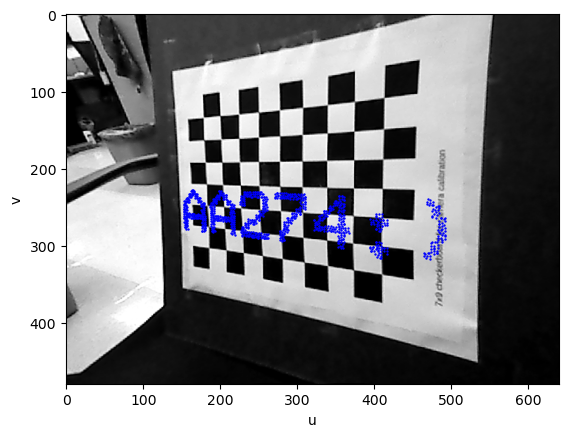

In [11]:
ax = plt.subplot()
ax.imshow(image, cmap="gray")
ax.set_xlabel("u")
ax.set_ylabel("v")

# Load the secrect point cloud from file!
point_cloud_secret = np.load("p1_data/secret.npy")
print(point_cloud_secret.shape)
# NOTE: Uncomment the lines below when you've finished everything else!
uv_secret = transform_world_to_camera(K, R, t, point_cloud_secret)
u = uv_secret[:,0]/uv_secret[:,2]
v = uv_secret[:,1]/uv_secret[:,2]
ax.scatter(u, v, s=0.5, c="b")